In [9]:
import cv2 
import glob 
import matplotlib.pyplot as plt
import numpy as np
import os 
import torch 

from importlib import import_module 

from skp.toolbox.functions import load_model_from_config

In [98]:
def add_buffer_to_box(coords, buffer=0.05, img_shape=None):
    # assumes coords is x, y, w, h 
    # buffer is for EACH SIDE (i.e., 0.05 will add total of 0.1)
    assert len(coords) == 4
    assert buffer >= 0
    if buffer == 0:
        return coords
    x1, y1, w, h = coords
    x2, y2 = x1 + w, y1 + h
    w_buff, h_buff = w * buffer, h * buffer
    x1 -= w_buff
    y1 -= h_buff
    x2 += w_buff
    y2 += h_buff
    x1, y1 = max(0, x1), max(0, y1)
    if img_shape is not None:
        x2, y2 = min(img_shape[1], x2), min(img_shape[0], y2)
    w, h = x2 - x1, y2 - y1
    return tuple([int(_) for _ in [x1, y1, w, h]])

In [122]:
def add_buffer_to_coords(coords: torch.Tensor, buffer: float | tuple[float, float] = 0.05):
    coords = coords.clone()
    empty = coords.int().sum(1) == 0
    # assumes coords is a torch.Tensor of shape (N, 4) containing
    # normalized x, y, w, h coordinates
    # buffer is for EACH SIDE (i.e., 0.05 will add total of 0.1)
    assert len(coords.shape) == 2
    assert coords.shape[1] == 4
    if isinstance(buffer, float):
        buffer = buffer, buffer
    assert buffer[0] >= 0 and buffer[1] >= 0
    assert coords.min() >= 0 and coords.max() <= 1
    if buffer == 0 or empty.sum() == coords.shape[0]:
        return coords
    # convert xywh->xyxy
    x1, y1, w, h = coords.unbind(1)
    x2, y2 = x1 + w, y1 + h
    # since coords are normalized, can use buffer value directly
    w_buf, h_buf = buffer
    x1 -= w_buf
    y1 -= h_buf
    x2 += w_buf
    y2 += h_buf
    x1, y1 = torch.clamp_min(x1, 0), torch.clamp_min(y1, 0)
    x2, y2 = torch.clamp_max(x2, 1), torch.clamp_max(y2, 1)
    w, h = x2 - x1, y2 - y1
    coords = torch.stack([x1, y1, w, h], dim=1)
    coords[empty] = 0
    assert coords.min() >= 0 and coords.max() <= 1
    return coords

In [4]:
cfg_name = "bodycrop.cfg_totalsegmentator"
cfg = import_module(f"skp.configs.{cfg_name}").cfg
cfg.pretrained = False
weights_path = os.path.join(cfg.save_dir, cfg_name, "98e6f453/fold0/checkpoints/last.ckpt")
model = load_model_from_config(cfg, weights_path=weights_path, device="cuda", eval_mode=True)

Loading weights from /home/ian/projects/SKP/experiments/bodycrop/bodycrop.cfg_totalsegmentator/98e6f453/fold0/checkpoints/last.ckpt ...


In [8]:
files = glob.glob("/mnt/stor/datasets/kaggle/rsna-intracranial-hemorrhage-detection/stage_2_train_png/*/*/*/*.png")
files[0]

'/mnt/stor/datasets/kaggle/rsna-intracranial-hemorrhage-detection/stage_2_train_png/ID_0317c747/ID_0df4704b49/ID_a6a7071ab4/IM0023_ID_b3ff89ba3.png'

/mnt/stor/datasets/kaggle/rsna-intracranial-hemorrhage-detection/stage_2_train_png/ID_e3fff24b/ID_ce3a52bb0f/ID_d19153da44/IM0028_ID_a7bf370c0.png
[[2.3589584e-01 1.9638555e-01 5.0273740e-01 6.8356574e-01]
 [4.1526214e-06 2.3576793e-06 2.4647661e-06 3.0871335e-05]]
[121 101 257 350]


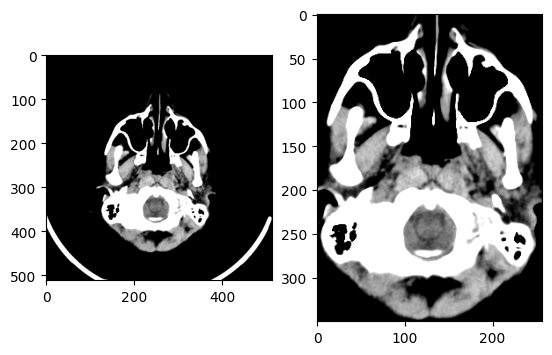

In [138]:
f = np.random.choice(files)
print(f)

img0 = cv2.imread(f, cv2.IMREAD_COLOR)[..., 0]
empty = np.zeros((cfg.image_width, cfg.image_height))
img = cv2.resize(img0, (cfg.image_width, cfg.image_height))
img = torch.from_numpy(img).expand(1, 1, -1, -1).float().to("cuda")
empty = torch.from_numpy(empty).expand(1, 1, -1, -1).float().to("cuda")

x = torch.cat([img ,empty])
with torch.inference_mode():
    pred = model({"x": x})

coords = add_buffer_to_coords(pred["logits"], buffer=(0.05, 0.10)).cpu().numpy()
print(coords)
coords = coords[0]
coords[[0, 2]] = coords[[0, 2]] * img0.shape[1]
coords[[1, 3]] = coords[[1, 3]] * img0.shape[0]
coords = np.round(coords).astype("int")
print(coords)
if coords.sum() == 0:
    coords = [0, 0, img0.shape[1], img0.shape[0]]
    
x, y, w, h = coords
img_crop = img0[y:y+h, x:x+w]

plt.subplot(1, 2, 1)
plt.imshow(img0, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(img_crop, cmap="gray")
plt.show()

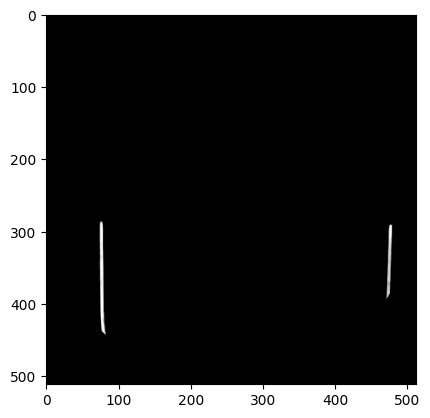

In [126]:
plt.imshow(img0, cmap="gray")
plt.show()

In [107]:
x = torch.randn((10, 4))
x.unbind(1)

(tensor([-0.1093,  1.2681, -0.3381,  0.8279,  0.7191, -0.9863,  2.3653, -0.5841,
         -1.0665,  0.7208]),
 tensor([ 0.1928, -0.2433, -0.7621, -0.7241, -1.1004,  1.0491, -0.8642,  0.0244,
         -1.6844,  1.7864]),
 tensor([ 0.2194, -0.5574,  0.0071, -1.0463, -0.3410,  0.6806,  0.2067,  0.8233,
         -1.2595, -0.3705]),
 tensor([ 0.5130,  0.0561,  0.8671,  0.6737,  1.7044, -0.2124, -0.4087, -0.4879,
         -0.3153, -0.9730]))

In [110]:
torch.clamp_max(x[:, 0], 0)

tensor([-0.1093,  0.0000, -0.3381,  0.0000,  0.0000, -0.9863,  0.0000, -0.5841,
        -1.0665,  0.0000])